## Setup

In [1]:
# Imports

# Standard library
import random
import sqlite3

# Numerical & Data Handling
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.stats import chi2_contingency, entropy

# Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from statsmodels.stats.proportion import proportions_ztest

# scikit-learn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix, 
                            ConfusionMatrixDisplay, silhouette_score, normalized_mutual_info_score, 
                            adjusted_rand_score)

In [2]:
# Instanciate: Vectorizer, PCA, KMeans, Classifiers

# Vectorizers
vectorizer = CountVectorizer(stop_words='english', min_df=2)
tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=2)

# Dim Reduction
pca = PCA(n_components=2)
pca_50 = PCA(n_components=50)

# Classifier Param Testing
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20, 50],
    'max_features': ['sqrt', 0.2, 0.5],
    'min_samples_leaf': [1, 2, 5],
    'class_weight': [None, 'balanced']
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1',
    cv=3,
    verbose=2,
    random_state=42
)

best_rf_params = {
    'n_estimators': 100,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'max_depth': None,
    'class_weight': 'balanced'
}

# Classifiers
clf_NB = MultinomialNB()
clf_RF = RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)

In [3]:
# Helper Functions
def print_lists_side_by_side(positive_list, negative_list, number, type):
    print(f"\n=== {type} Component #{number} ===\n")
    print(f"{'Negative':<30} {'Positive'}")
    print("-" * 50)

    # Find the longer of the two lists
    max_len = max(len(positive_list), len(negative_list))

    for i in range(max_len):
        neg_item = negative_list[i] if i < len(negative_list) else ""
        pos_item = positive_list[i] if i < len(positive_list) else ""
        print(f"{i+1:>2}: {neg_item:<27} {pos_item}")

In [4]:
# Build DF from DB, Remove NULL entries
conn = sqlite3.connect("../WELFake_Dataset.db")
df = pd.read_sql(
    "SELECT * FROM WELFake_Dataset WHERE title IS NOT NULL", 
    conn,  
    index_col="id"
)

In [5]:
# Split DF
titles = df['title']
labels = df['label']
titles_train, titles_test, labels_train, labels_test = train_test_split(
    titles,
    labels,
    test_size=0.3,
    stratify=labels,
    random_state=42
)

In [6]:
# Check DF
df.info(verbose=True)
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 71576 entries, 0 to 72133
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   71576 non-null  object
 1   text    71537 non-null  object
 2   label   71576 non-null  object
dtypes: object(3)
memory usage: 2.2+ MB


,title,text,label
id,,,
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1


In [7]:
# Get Sample
sample = df.sample(n=10000, random_state=42)
titles_sample = sample['title'].tolist()
labels_sample = sample['label'].tolist()

# Count fake labels
sample_fake = sum([1 for label in labels_sample if label == "1"])
full_fake = sum([1 for label in labels if label == "1"])

# Proportion Z-test
count = np.array([sample_fake, full_fake])
nobs = np.array([len(sample), len(labels)])

stat, pval = proportions_ztest(count, nobs)
print(f"Z-test p-value: {pval:.5f}")

Z-test p-value: 0.66402


## Visualize Data with Count Vectorizing, PCA, and K-means

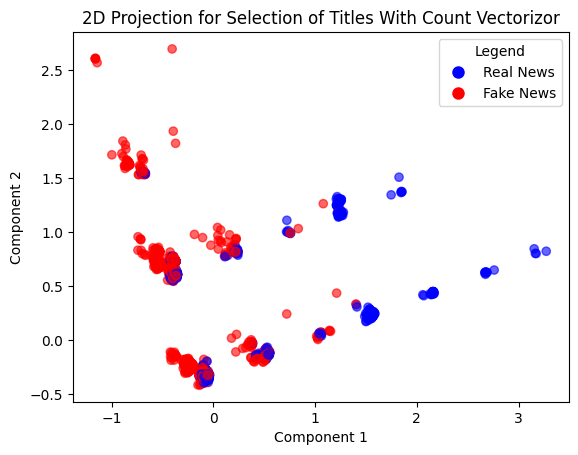

In [8]:
# Visualize Data with PCA (With Count)

# Vectorize with Count
x_sample = vectorizer.fit_transform(titles_sample).toarray()

# Reduce
x_pca = pca.fit_transform(x_sample)
x_pca_50 = pca_50.fit_transform(x_sample)

# Plot
colors = [ "blue" if label=='0' else "red" for label in labels_sample ]

plt.scatter(
    x_pca[:, 0],
    x_pca[:, 1],
    c=colors,
    alpha=0.6
)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Real News', 
           markerfacecolor='blue', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Fake News', 
           markerfacecolor='red', markersize=10)
]

plt.legend(handles=legend_elements, title="Legend")

plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("2D Projection for Selection of Titles With Count Vectorizor")
plt.show()

In [9]:
# Words Driving PC1

# Words in your CountVectorizer
feature_names = vectorizer.get_feature_names_out()

# PCA components
components = pca.components_

# Top words contributing to PC1 (positive)
pc1_top_indices_p = components[0].argsort()[::-1][:20]
top_words_pc1_p = feature_names[pc1_top_indices_p]

# Top words contributing to PC1 (negative)
pc1_top_indices_n = components[0].argsort()[:20]
top_words_pc1_n = feature_names[pc1_top_indices_n]

print_lists_side_by_side(top_words_pc1_p,top_words_pc1_n,1, "PCA")


=== PCA Component #1 ===

Negative                       Positive
--------------------------------------------------
 1: trump                       new
 2: video                       york
 3: watch                       times
 4: just                        briefing
 5: president                   today
 6: hillary                     review
 7: obama                       california
 8: says                        evening
 9: breitbart                   dies
10: white                       say
11: house                       home
12: gop                         rio
13: media                       killed
14: anti                        let
15: breaking                    city
16: donald                      american
17: cnn                         kills
18: clinton                     books
19: supporters                  syria
20: supporter                   isis


In [10]:
# Words Driving PC2

# Top words contributing to PC2 (positive)
pc2_top_indices_p = components[1].argsort()[::-1][:20]
top_words_pc2_p = feature_names[pc2_top_indices_p]

# Top words contributing to PC2 (negative)
pc2_top_indices_n = components[1].argsort()[:20]
top_words_pc2_n = feature_names[pc2_top_indices_n]

print_lists_side_by_side(top_words_pc2_p,top_words_pc2_n,2, "PCA")


=== PCA Component #2 ===

Negative                       Positive
--------------------------------------------------
 1: hillary                     trump
 2: obama                       new
 3: state                       york
 4: eu                          times
 5: says                        donald
 6: election                    video
 7: police                      president
 8: clinton                     watch
 9: 2016                        supporters
10: fbi                         just
11: turkey                      supporter
12: brexit                      campaign
13: senate                      ban
14: iran                        anti
15: minister                    tweets
16: islamic                     win
17: government                  cnn
18: gun                         twitter
19: syria                       rally
20: court                       administration


[np.float64(0.47837741243745535), np.float64(0.019943019943019943), np.float64(0.5866495507060334), np.float64(0.03067484662576687), np.float64(0.9047619047619048), np.float64(0.5986159169550173), np.float64(0.974587039390089), np.float64(0.0)]
Overall fake news percentage in sample: 0.508


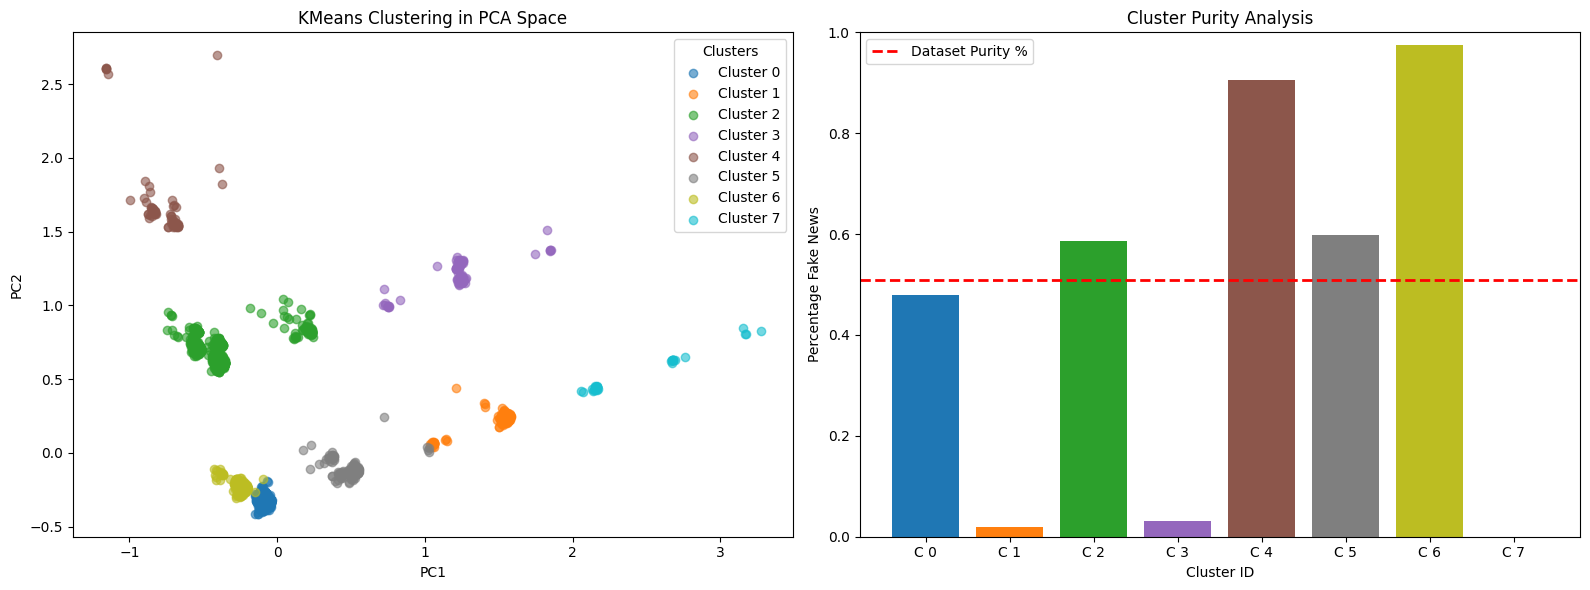

In [11]:
# Perform Cluster Analysis

# Clustering
num_clusters = 8
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Use modern colormap API
cmap = plt.get_cmap("tab10", num_clusters)

# Run KMeans clustering
cluster_labels = kmeans.fit_predict(x_pca)

# Calculate fake news percentage in each cluster
counts = []
for cluster_id in np.unique(cluster_labels):
    mask = cluster_labels == cluster_id
    labels_in_cluster = np.array(labels_sample)[mask]
    fake_pct = np.sum(labels_in_cluster == '1') / len(labels_in_cluster)
    counts.append(fake_pct)
print(counts)

# Calculate overall purity of entire sample
labels_sample_array = np.array(labels_sample)
overall_fake_pct = np.sum(labels_sample_array == '1') / len(labels_sample_array)
print(f"Overall fake news percentage in sample: {overall_fake_pct:.3f}")

# Create figure with 2 side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot in first subplot
ax = axes[0]

for cluster_id in np.unique(cluster_labels):
    mask = cluster_labels == cluster_id
    ax.scatter(
        x_pca[mask, 0],
        x_pca[mask, 1],
        label=f"Cluster {cluster_id}",
        color=cmap(cluster_id),
        alpha=0.6
    )

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("KMeans Clustering in PCA Space")
ax.legend(title="Clusters")

# Bar chart in second subplot
ax = axes[1]

bars = ax.bar(
    range(len(counts)),
    counts,
    color=[cmap(i) for i in range(len(counts))]
)

# Add horizontal line for overall sample purity
ax.axhline(overall_fake_pct, color='red', linestyle='--', linewidth=2, label='Dataset Purity %')

ax.set_xlabel("Cluster ID")
ax.set_ylabel("Percentage Fake News")
ax.set_title("Cluster Purity Analysis")
ax.set_xticks(range(len(counts)))
ax.set_xticklabels([f"C {i}" for i in range(len(counts))])
ax.set_ylim(0, 1)
ax.legend()

plt.tight_layout()
plt.show()

In [12]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Assuming your true labels:
# true_labels = ...

k_values = list(range(2, 31))
results = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(x_pca)

    ari = adjusted_rand_score(labels_sample, labels)
    nmi = normalized_mutual_info_score(labels_sample, labels)
    sil = silhouette_score(x_pca, labels)

    results.append({
        "k": k,
        "silhouette": sil,
        "inertia": kmeans.inertia_,  # sum-squares diff between centroid and elements
        "ari": ari,
        "nmi": nmi
    })

import pandas as pd
df_results = pd.DataFrame(results)
print(df_results)

     k  silhouette      inertia       ari       nmi
0    2    0.738308  2436.602278  0.035663  0.115852
1    3    0.869730   480.761418  0.025233  0.077318
2    4    0.878360   340.805703  0.020882  0.075216
3    5    0.885155   243.058604  0.019781  0.076070
4    6    0.893591   135.447034  0.018562  0.073713
5    7    0.892535   111.292035  0.018443  0.072766
6    8    0.856592    79.545952  0.025026  0.107909
7    9    0.805551    65.291959  0.024968  0.123047
8   10    0.828698    39.294657  0.025024  0.120830
9   11    0.831572    31.307786  0.024799  0.122049
10  12    0.832709    26.443180  0.024783  0.121896
11  13    0.832919    23.245349  0.024818  0.122474
12  14    0.833650    17.147773  0.024803  0.122409
13  15    0.834518    14.995716  0.024769  0.122272
14  16    0.830895    12.618644  0.024657  0.121040
15  17    0.617854    11.529294  0.024260  0.106924
16  18    0.617047    11.110406  0.024255  0.106901
17  19    0.617415    10.277255  0.024254  0.106865
18  20    0.

In [13]:
# Determine Cluster Predictivity
# Predictiveness via classifier
cluster_onehot = pd.get_dummies(cluster_labels, prefix="Cluster")
clf = LogisticRegression(max_iter=1000)
acc = cross_val_score(clf, cluster_onehot, labels_sample, scoring='accuracy', cv=5).mean()

# Direct metrics
ari = adjusted_rand_score(labels_sample, cluster_labels)
nmi = normalized_mutual_info_score(labels_sample, cluster_labels)
sil = silhouette_score(x_pca, cluster_labels)

# 1. Accuracy [0, 1]: predictive capability
# 2. Adjusted Rand Index (ARI) [-1,1]: cluster alignment with other items in cluster
# 3. Normalized Mutual Information (NMI) [0, 1]: info about dep vrb from cluster
# 4. Sihouette Score [-1,1]: how distinct are the clusters

print(f"Accuracy (logreg): {acc:.3f}")
print(f"ARI: {ari:.3f}, NMI: {nmi:.3f}")
print(f"Silhouette: {sil:.3f}")

Accuracy (logreg): 0.619
ARI: 0.025, NMI: 0.108
Silhouette: 0.857


## Visualize Data with TF-IDF Vectorizing, PCA, and Gaussian Mixture

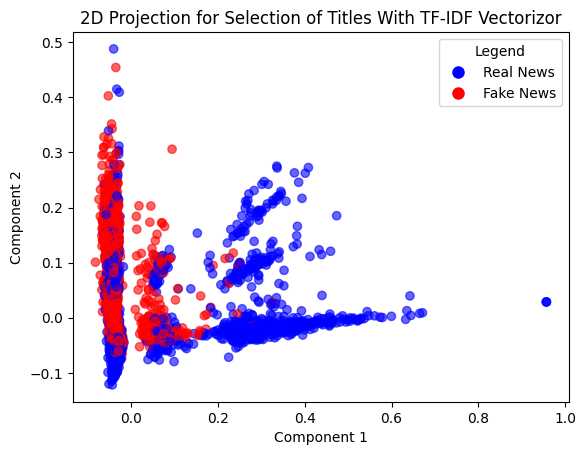

In [14]:
# Visualize Data with PCA (With Count)

# Vectorize
x_sample = tfidf_vectorizer.fit_transform(titles_sample).toarray()

# Reduce
x_pca = pca.fit_transform(x_sample)

# Plot
colors = [ "blue" if label=='0' else "red" for label in labels_sample ]

plt.scatter(
    x_pca[:, 0],
    x_pca[:, 1],
    c=colors,
    alpha=0.6
)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Real News', 
           markerfacecolor='blue', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Fake News', 
           markerfacecolor='red', markersize=10)
]

plt.legend(handles=legend_elements, title="Legend")

plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("2D Projection for Selection of Titles With TF-IDF Vectorizor")
plt.show()

In [15]:
# Words Driving PC1

# Words in your CountVectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# PCA components
components = pca.components_

# Top words contributing to PC1 (positive)
pc1_top_indices_p = components[0].argsort()[::-1][:20]
top_words_pc1_p = feature_names[pc1_top_indices_p]

# Top words contributing to PC1 (negative)
pc1_top_indices_n = components[0].argsort()[:20]
top_words_pc1_n = feature_names[pc1_top_indices_n]

print_lists_side_by_side(top_words_pc1_p,top_words_pc1_n,1, "PCA")


=== PCA Component #1 ===

Negative                       Positive
--------------------------------------------------
 1: video                       new
 2: trump                       york
 3: says                        times
 4: hillary                     donald
 5: watch                       briefing
 6: breitbart                   today
 7: just                        california
 8: house                       review
 9: obama                       evening
10: gop                         home
11: white                       fight
12: clinton                     dies
13: media                       rio
14: breaking                    let
15: fbi                         say
16: president                   books
17: iran                        american
18: russia                      city
19: senate                      wednesday
20: republican                  world


In [16]:
# Words Driving PC2

# Top words contributing to PC2 (positive)
pc2_top_indices_p = components[1].argsort()[::-1][:20]
top_words_pc2_p = feature_names[pc2_top_indices_p]

# Top words contributing to PC2 (negative)
pc2_top_indices_n = components[1].argsort()[:20]
top_words_pc2_n = feature_names[pc2_top_indices_n]

print_lists_side_by_side(top_words_pc2_p,top_words_pc2_n,2, "PCA")


=== PCA Component #2 ===

Negative                       Positive
--------------------------------------------------
 1: says                        trump
 2: north                       donald
 3: korea                       video
 4: eu                          president
 5: state                       clinton
 6: brexit                      hillary
 7: china                       campaign
 8: police                      just
 9: minister                    watch
10: syria                       supporters
11: iran                        win
12: turkey                      supporter
13: talks                       york
14: islamic                     media
15: government                  times
16: pm                          tweets
17: election                    new
18: senate                      white
19: britain                     anti
20: uk                          speech


[np.float64(0.4847361535106847), np.float64(0.06914212548015365), np.float64(0.6333333333333333), np.float64(0.05365853658536585), np.float64(0.6006944444444444)]
Overall fake news percentage in sample: 0.508


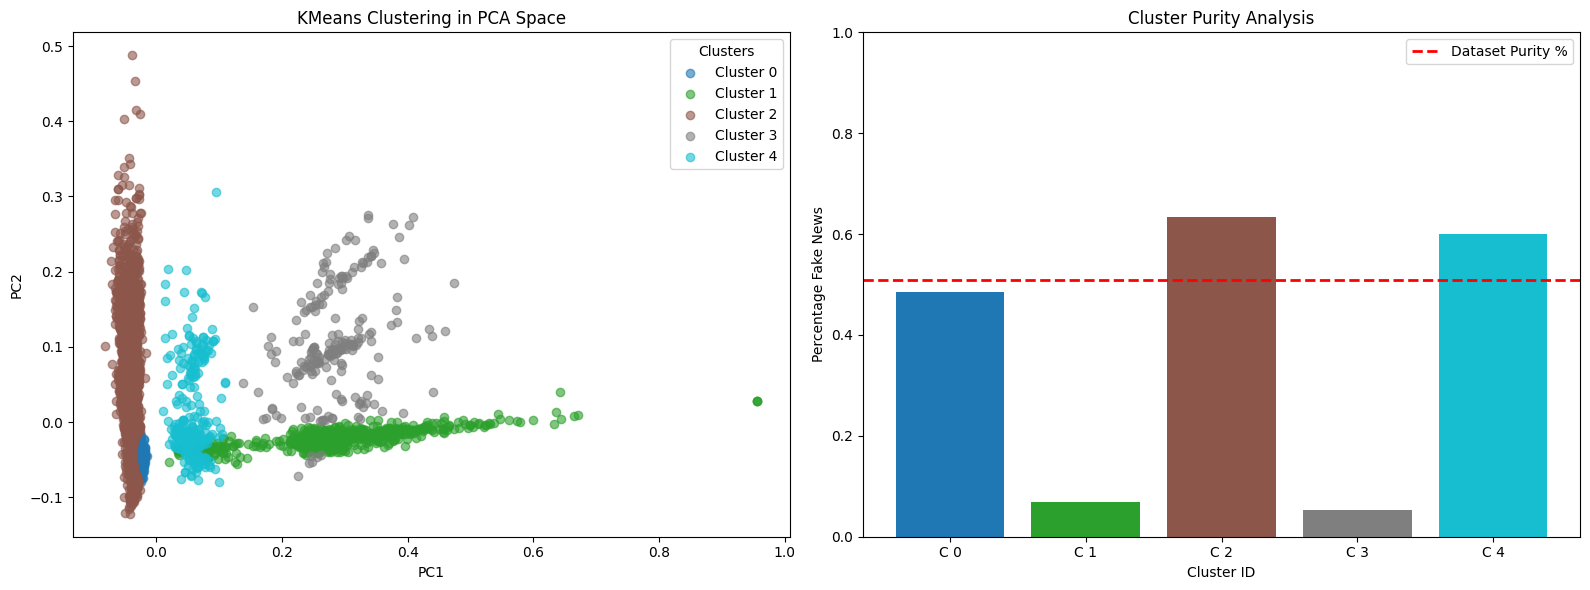

In [17]:
# Perform Cluster Analysis

num_clusters = 5
gmm = GaussianMixture(n_components=num_clusters, random_state=42)

# Use modern colormap API
cmap = plt.get_cmap("tab10", num_clusters)

# Run Gaussian clustering
cluster_labels = gmm.fit_predict(x_pca)
cluster_labels_50 = gmm.fit_predict(x_pca_50)

# Calculate fake news percentage in each cluster
counts = []
for cluster_id in np.unique(cluster_labels):
    mask = cluster_labels == cluster_id
    labels_in_cluster = np.array(labels_sample)[mask]
    fake_pct = np.sum(labels_in_cluster == '1') / len(labels_in_cluster)
    counts.append(fake_pct)
print(counts)

# Calculate overall purity of entire sample
labels_sample_array = np.array(labels_sample)
overall_fake_pct = np.sum(labels_sample_array == '1') / len(labels_sample_array)
print(f"Overall fake news percentage in sample: {overall_fake_pct:.3f}")

# Create figure with 2 side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot in first subplot
ax = axes[0]

for cluster_id in np.unique(cluster_labels):
    mask = cluster_labels == cluster_id
    ax.scatter(
        x_pca[mask, 0],
        x_pca[mask, 1],
        label=f"Cluster {cluster_id}",
        color=cmap(cluster_id),
        alpha=0.6
    )

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("KMeans Clustering in PCA Space")
ax.legend(title="Clusters")

# Bar chart in second subplot
ax = axes[1]

bars = ax.bar(
    range(len(counts)),
    counts,
    color=[cmap(i) for i in range(len(counts))]
)

# Add horizontal line for overall sample purity
ax.axhline(overall_fake_pct, color='red', linestyle='--', linewidth=2, label='Dataset Purity %')

ax.set_xlabel("Cluster ID")
ax.set_ylabel("Percentage Fake News")
ax.set_title("Cluster Purity Analysis")
ax.set_xticks(range(len(counts)))
ax.set_xticklabels([f"C {i}" for i in range(len(counts))])
ax.set_ylim(0, 1)
ax.legend()

plt.tight_layout()
plt.show()

In [18]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Assuming your true labels:
# true_labels = ...

k_values = list(range(2, 31))
results = []

for k in k_values:
    gmm = GaussianMixture(n_components=k, random_state=42)
    labels = gmm.fit_predict(x_pca)

    ari = adjusted_rand_score(labels_sample, labels)
    nmi = normalized_mutual_info_score(labels_sample, labels)
    sil = silhouette_score(x_pca, labels)

    results.append({
        "k": k,
        "silhouette": sil,
        "ari": ari,
        "nmi": nmi
    })

import pandas as pd
df_results = pd.DataFrame(results)
print(df_results)

     k  silhouette       ari       nmi
0    2    0.671092  0.024845  0.039448
1    3    0.449664  0.037063  0.049443
2    4    0.434687  0.033569  0.050845
3    5    0.454635  0.034229  0.066775
4    6    0.383180  0.022926  0.065103
5    7    0.387887  0.019172  0.066958
6    8    0.466772  0.031043  0.072105
7    9    0.470191  0.032846  0.074311
8   10    0.468295  0.031707  0.075458
9   11    0.453010  0.030914  0.071624
10  12    0.469691  0.031075  0.075152
11  13    0.471344  0.030656  0.076095
12  14    0.414978  0.031811  0.080179
13  15    0.420410  0.035356  0.086758
14  16    0.434527  0.031400  0.086698
15  17    0.425461  0.023041  0.081529
16  18    0.415679  0.023033  0.081706
17  19    0.389025  0.026292  0.082687
18  20    0.371461  0.024940  0.083837
19  21    0.328140  0.024686  0.085477
20  22    0.334631  0.024399  0.084071
21  23    0.356853  0.023742  0.085289
22  24    0.346856  0.024923  0.087036
23  25    0.377074  0.023251  0.084990
24  26    0.359093  0.023

In [19]:
# Determine Cluster Predictivity
# Predictiveness via classifier
cluster_onehot = pd.get_dummies(cluster_labels, prefix="Cluster")
clf = LogisticRegression(max_iter=1000)
acc = cross_val_score(clf, cluster_onehot, labels_sample, scoring='accuracy', cv=5).mean()

# Direct metrics
ari = adjusted_rand_score(labels_sample, cluster_labels)
nmi = normalized_mutual_info_score(labels_sample, cluster_labels)
sil = silhouette_score(x_pca, cluster_labels)

# 1. Accuracy [0, 1]: predictive capability
# 2. Adjusted Rand Index (ARI) [-1,1]: cluster alignment with other items in cluster
# 3. Normalized Mutual Information (NMI) [0, 1]: info about dep vrb from cluster
# 4. Sihouette Score [-1,1]: how distinct are the clusters

print(f"Accuracy (logreg): {acc:.3f}")
print(f"ARI: {ari:.3f}, NMI: {nmi:.3f}")
print(f"Silhouette: {sil:.3f}")

Accuracy (logreg): 0.608
ARI: 0.034, NMI: 0.067
Silhouette: 0.455


## Build and Tune Classifiers

### Data Prep

In [20]:
# Vectorize
x_train = tfidf_vectorizer.transform(titles_train)
x_test = tfidf_vectorizer.transform(titles_test)

In [21]:
# Reduce
x_train_reduced = pca_50.transform(x_train)
x_test_reduced = pca_50.transform(x_test)

In [22]:
# Cluster
kmeans.fit_predict(x_pca_50)
cluster_labels_train = kmeans.predict(x_train_reduced)
cluster_labels_test = kmeans.predict(x_test_reduced)

### Naive Bayes

In [23]:
# Fit NB
clf_NB.fit(x_train, labels_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [24]:
# Predict
y_pred = clf_NB.predict(x_test)
print("Accuracy: ", accuracy_score(labels_test, y_pred))
print(classification_report(labels_test, y_pred))

Accuracy:  0.8713733525823126
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     10508
           1       0.87      0.88      0.87     10965

    accuracy                           0.87     21473
   macro avg       0.87      0.87      0.87     21473
weighted avg       0.87      0.87      0.87     21473



### Random Forest

In [20]:
# Determine RF Best Params
y_train_int = labels_train.astype(int).tolist()
random_search.fit(x_train, y_train_int)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END class_weight=balanced, max_depth=50, max_features=0.2, min_samples_leaf=2, n_estimators=100; total time=   9.1s
[CV] END class_weight=balanced, max_depth=50, max_features=0.2, min_samples_leaf=2, n_estimators=100; total time=   9.1s
[CV] END class_weight=balanced, max_depth=50, max_features=0.2, min_samples_leaf=2, n_estimators=100; total time=   9.4s
[CV] END class_weight=balanced, max_depth=50, max_features=0.5, min_samples_leaf=5, n_estimators=100; total time=  14.8s
[CV] END class_weight=balanced, max_depth=50, max_features=0.5, min_samples_leaf=5, n_estimators=100; total time=  14.9s
[CV] END class_weight=balanced, max_depth=50, max_features=0.5, min_samples_leaf=5, n_estimators=100; total time=  15.1s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, n_estimators=100; total time=   0.4s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, n_esti

,estimator,RandomForestC...ndom_state=42)
,param_distributions,"{'class_weight': [None, 'balanced'], 'max_depth': [None, 10, ...], 'max_features': ['sqrt', 0.2, ...], 'min_samples_leaf': [1, 2, ...], ...}"
,n_iter,20
,scoring,'f1'
,n_jobs,None
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [21]:
# Find Best Params
print(random_search.best_params_)
print(random_search.best_score_)

best_model = random_search.best_estimator_

# evaluate on test
y_test_int = labels_test.astype(int)
y_pred = best_model.predict(x_test)
print(classification_report(y_test_int, y_pred, digits=3))

# Results
# {'n_estimators': 100, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced'}

{'n_estimators': 100, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced'}
0.887820008251066
              precision    recall  f1-score   support

           0      0.899     0.886     0.892     10508
           1      0.892     0.904     0.898     10965

    accuracy                          0.895     21473
   macro avg      0.895     0.895     0.895     21473
weighted avg      0.895     0.895     0.895     21473



In [25]:
# Fit RF Classifier (built with best params)
clf_RF.fit(x_train, labels_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [26]:
# Check RF Classifier Accuracy
y_pred = clf_RF.predict(x_test)
print("Accuracy: ", accuracy_score(labels_test, y_pred))
print(classification_report(labels_test, y_pred))

Accuracy:  0.8857635169748056
              precision    recall  f1-score   support

           0       0.88      0.89      0.88     10508
           1       0.89      0.89      0.89     10965

    accuracy                           0.89     21473
   macro avg       0.89      0.89      0.89     21473
weighted avg       0.89      0.89      0.89     21473



## Build Composit Classifier

In [27]:
# Find Word Count (title_word_count)
titles_training_wc = np.array([len(title.split()) for title in titles_train]).reshape(-1, 1)
titles_training_wc = sparse.csr_matrix(titles_training_wc)

titles_test_wc = np.array([len(title.split()) for title in titles_test]).reshape(-1, 1)
titles_test_wc = sparse.csr_matrix(titles_test_wc)

In [28]:
# Find % Fake News per Cluster
labels_train_arr = np.array(labels_train)
labels_train_int = (labels_train_arr == '1').astype(int)

cluster_fake_pct_dict = {}
for cluster_id in np.unique(cluster_labels_train):
    mask = cluster_labels_train == cluster_id
    labels_in_cluster = labels_train_int[mask]
    fake_pct = np.sum(labels_in_cluster) / len(labels_in_cluster)
    cluster_fake_pct_dict[cluster_id] = fake_pct

In [29]:
# Create Cluster Features (cluster_id_feature_train, cluster_fake_pct_feature_train)

# Training Set
cluster_id_feature_train = cluster_labels_train.reshape(-1, 1)

cluster_fake_pct_feature_train = np.array([
    cluster_fake_pct_dict[cid] for cid in cluster_labels_train
]).reshape(-1, 1)

# Test Set
cluster_id_feature_test = cluster_labels_test.reshape(-1, 1)

cluster_fake_pct_feature_test = np.array([
    cluster_fake_pct_dict.get(cid, 0.5) for cid in cluster_labels_test
]).reshape(-1, 1)

In [30]:
# Create NB Feature (nb_probs_train)

# Training Set
nb_probs_train = clf_NB.predict_proba(x_train)[:, 1].reshape(-1, 1)

# Test Set
nb_probs_test = clf_NB.predict_proba(x_test)[:, 1].reshape(-1, 1)

In [31]:
# Combine

# Train
x_train_combined = sparse.hstack([
    x_train,
    cluster_id_feature_train,
    cluster_fake_pct_feature_train,
    nb_probs_train,
    titles_training_wc
])

# Test
x_test_combined = sparse.hstack([
    x_test,
    cluster_id_feature_test,
    cluster_fake_pct_feature_test,
    nb_probs_test,
    titles_test_wc
])

In [32]:
# Fit and Check RF Composit Classifier
clf_RF.fit(x_train_combined, labels_train)

# Predict on test set
y_pred = clf_RF.predict(x_test_combined)

# Evaluate
print(classification_report(labels_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.913     0.901     0.907     10508
           1      0.906     0.918     0.912     10965

    accuracy                          0.909     21473
   macro avg      0.910     0.909     0.909     21473
weighted avg      0.910     0.909     0.909     21473



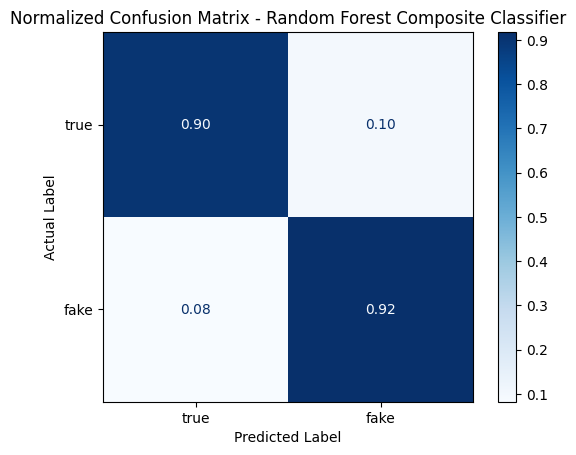

In [33]:
# Check Normalized Confusion Matrix

# Define labels
label_mapping = {
    "0": "true",
    "1": "fake"
}

custom_labels = ["true", "fake"]

# Normalized confusion matrix
cm_normalized = confusion_matrix(
    labels_test,
    y_pred,
    labels=["0", "1"],
    normalize='true'
)

disp_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_normalized,
                                         display_labels=custom_labels)

disp_normalized.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.title("Normalized Confusion Matrix - Random Forest Composite Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

## Check Classifier with New Titles

In [35]:
# Classify Titles
new_titles = [
    # Real news examples
    "Scientists discover new planet",
    "Local elections see record turnout",
    "New study shows benefits of exercise",
    "Government releases economic forecast",
    "NASA announces new Mars mission",
    "Researchers develop promising cancer treatment",
    "Weather service warns of approaching storm",
    "UN holds emergency meeting on global conflict",
    "Tech company reports surge in quarterly profits",
    "Historic peace deal signed between nations",

    # Fake news examples
    "Politician caught in alien conspiracy",
    "Doctors hide cure for cancer to protect profits",
    "New world order plans revealed by secret documents",
    "Scientists admit Earth is flat in shocking report",
    "Celebrity reveals time travel secrets on live TV",
    "Government replaces citizens with clones",
    "Bill Gates microchips confirmed in vaccines",
    "Alien bases discovered under the White House",
    "Vampires spotted in national park",
    "FBI confirms psychic powers exist"
]

# Vector Feature
vectors = tfidf_vectorizer.transform(new_titles)

# Find Word Count (title_word_count)
titles_wc = np.array([len(title.split()) for title in new_titles]).reshape(-1, 1)
titles_wc = sparse.csr_matrix(titles_wc)

# NB Feature
nb_probs = clf_NB.predict_proba(vectors)[:, 1].reshape(-1, 1)

# Reduce
reduced = pca_50.transform(vectors)

# Cluster
clusters = kmeans.predict(reduced)

# Cluster ID Feature
cluster_ids = clusters.reshape(-1, 1)

# Cluster Fake Pct Feature
cluster_fake_pct_dict = {cid: 0.5 for cid in np.unique(clusters)}

cluster_fake_pct = np.array([
    cluster_fake_pct_dict[cid] for cid in clusters
]).reshape(-1, 1)

# Combine Features
combined = sparse.hstack([
    vectors,
    cluster_ids,
    cluster_fake_pct,
    nb_probs,
    titles_wc
])

predictions = clf_RF.predict(combined)

for title, label in zip(new_titles, predictions):
    result = 'True' if label == '0' else 'Fake'
    print(f"Title: {title}\nPredicted label: {result}\n")

Title: Scientists discover new planet
Predicted label: Fake

Title: Local elections see record turnout
Predicted label: Fake

Title: New study shows benefits of exercise
Predicted label: True

Title: Government releases economic forecast
Predicted label: Fake

Title: NASA announces new Mars mission
Predicted label: True

Title: Researchers develop promising cancer treatment
Predicted label: Fake

Title: Weather service warns of approaching storm
Predicted label: Fake

Title: UN holds emergency meeting on global conflict
Predicted label: True

Title: Tech company reports surge in quarterly profits
Predicted label: True

Title: Historic peace deal signed between nations
Predicted label: True

Title: Politician caught in alien conspiracy
Predicted label: Fake

Title: Doctors hide cure for cancer to protect profits
Predicted label: Fake

Title: New world order plans revealed by secret documents
Predicted label: Fake

Title: Scientists admit Earth is flat in shocking report
Predicted label: